# Generate synthetic data and then process it the same as the vibe coded app should process it

In [43]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:

def generate_synthetic_proteomics(
    n_proteins: int = 1000,
    n_reps_per_condition: int = 5,
    frac_de: float = 0.01,
    log2fc_values: tuple = (-2.0, -1.0, 1.0, 2.0),
    de_prob_by_fc: tuple = (0.2, 0.3, 0.3, 0.2),
    base_log2_mean: float = 25.0,
    base_log2_sd: float = 1.0,
    noise_sd: float = 0.3,
    missing_rate_overall: float = 0.05,
    missing_low_intensity_boost: float = 0.15,
    random_state: int = 42,
):
    """
    Generate a synthetic proteomics style dataset with known ground truth.

    Returns
    -------
    wide_df : DataFrame
        Proteins x samples matrix.
        First column is 'Protein' followed by columns 'A_1', ..., 'A_n', 'B_1', ..., 'B_n'.

    ref_de : DataFrame
        Reference differential expression results with known ground truth:
        columns: ['Protein', 'is_de', 'true_log2fc', 'log2fc_hat',
                  'p_value', 'q_value', 'mean_A', 'mean_B'].

    tidy_df : DataFrame
        Long format table with columns ['Protein', 'Condition', 'Replicate', 'Intensity'].
    """
    rng = np.random.default_rng(random_state)

    # protein IDs
    proteins = np.array([f"Prot_{i:04d}" for i in range(n_proteins)])

    # assign DE status
    n_de = int(n_proteins * frac_de)
    de_indices = rng.choice(n_proteins, size=n_de, replace=False)
    is_de = np.zeros(n_proteins, dtype=bool)
    is_de[de_indices] = True

    # assign true log2 fold changes for DE proteins
    log2fc_array = np.zeros(n_proteins)
    if n_de > 0:
        chosen_fcs = rng.choice(
            log2fc_values,
            size=n_de,
            p=np.array(de_prob_by_fc) / np.sum(de_prob_by_fc),
        )
        log2fc_array[de_indices] = chosen_fcs

    # baseline log2 intensities per protein
    base_log2 = rng.normal(loc=base_log2_mean, scale=base_log2_sd, size=n_proteins)

    # condition specific means
    # condition A is baseline, condition B gets baseline + log2fc
    mean_A = base_log2
    mean_B = base_log2 + log2fc_array

    # generate replicate intensities with noise in log2 space
    def simulate_condition_means(means, n_reps):
        # shape: (n_proteins, n_reps)
        noise = rng.normal(loc=0.0, scale=noise_sd, size=(n_proteins, n_reps))
        return means[:, None] + noise

    log2_A = simulate_condition_means(mean_A, n_reps_per_condition)
    log2_B = simulate_condition_means(mean_B, n_reps_per_condition)

    # convert to linear intensities
    A_int = np.power(2.0, log2_A)
    B_int = np.power(2.0, log2_B)

    # introduce missingness
    if missing_rate_overall > 0 or missing_low_intensity_boost > 0:
        all_int = np.concatenate([A_int, B_int], axis=1)

        # per value missingness probability increases for low intensity
        log2_all = np.log2(all_int + 1e-8)

        # standardize to roughly 0..1
        z = (log2_all - log2_all.mean()) / (log2_all.std() + 1e-8)

        # low z means low intensity, so higher missing probability
        prob_missing = (
            missing_rate_overall
            + missing_low_intensity_boost * stats.norm.cdf(-z)
        )
        prob_missing = np.clip(prob_missing, 0.0, 0.95)

        mask = rng.uniform(size=all_int.shape) < prob_missing
        all_int[mask] = np.nan

        # split back to A and B
        A_int = all_int[:, :n_reps_per_condition]
        B_int = all_int[:, n_reps_per_condition:]

    # build wide format DataFrame
    A_cols = [f"A_{i+1}" for i in range(n_reps_per_condition)]
    B_cols = [f"B_{i+1}" for i in range(n_reps_per_condition)]

    wide_df = pd.DataFrame(
        np.concatenate([A_int, B_int], axis=1),
        columns=A_cols + B_cols,
        index=proteins,
    ).reset_index()
    wide_df.rename(columns={"index": "Protein"}, inplace=True)

    # convert to tidy format
    tidy_rows = []
    for i, prot in enumerate(proteins):
        for j, col in enumerate(A_cols):
            tidy_rows.append(
                {
                    "Protein": prot,
                    "Condition": "A",
                    "Replicate": j + 1,
                    "Intensity": A_int[i, j],
                }
            )
        for j, col in enumerate(B_cols):
            tidy_rows.append(
                {
                    "Protein": prot,
                    "Condition": "B",
                    "Replicate": j + 1,
                    "Intensity": B_int[i, j],
                }
            )

    tidy_df = pd.DataFrame(tidy_rows)

    # drop rows with nan intensity for DE calculation
    tidy_non_missing = tidy_df.dropna(subset=["Intensity"]).copy()
    tidy_non_missing["log2Intensity"] = np.log2(tidy_non_missing["Intensity"])

    # compute per protein stats
    ref_rows = []
    for i, prot in enumerate(proteins):
        sub = tidy_non_missing[tidy_non_missing["Protein"] == prot]
        subA = sub[sub["Condition"] == "A"]["log2Intensity"]
        subB = sub[sub["Condition"] == "B"]["log2Intensity"]

        if len(subA) < 2 or len(subB) < 2:
            # too few values to compute t test
            log2fc_hat = np.nan
            pval = np.nan
            mean_A_hat = np.nan
            mean_B_hat = np.nan
        else:
            mean_A_hat = subA.mean()
            mean_B_hat = subB.mean()
            log2fc_hat = mean_B_hat - mean_A_hat
            # standard two sided t test
            tstat, pval = stats.ttest_ind(
                subB, subA, equal_var=False, nan_policy="omit"
            )

        ref_rows.append(
            {
                "Protein": prot,
                "is_de": bool(is_de[i]),
                "true_log2fc": float(log2fc_array[i]),
                "log2fc_hat": log2fc_hat,
                "p_value": pval,
                "mean_A": mean_A_hat,
                "mean_B": mean_B_hat,
            }
        )

    ref_de = pd.DataFrame(ref_rows)

    # Benjamini Hochberg q values
    # Benjamini Hochberg q values
    mask_valid = ref_de["p_value"].notna()
    pvals = ref_de.loc[mask_valid, "p_value"].values
    m = len(pvals)

    # sort p values
    order = np.argsort(pvals)
    ranked_p = pvals[order]
    ranks = np.arange(1, m + 1)

    # raw BH q in sorted order
    q_sorted = ranked_p * m / ranks

    # enforce monotonicity from largest to smallest
    q_sorted = np.minimum.accumulate(q_sorted[::-1])[::-1]

    # map back to original order
    qvals = np.empty_like(q_sorted)
    qvals[order] = q_sorted

    ref_de["q_value"] = np.nan
    ref_de.loc[mask_valid, "q_value"] = qvals


    return wide_df, ref_de, tidy_df


In [84]:
wide_df, ref_de, tidy_df = generate_synthetic_proteomics()

In [85]:
wide_df.set_index('Protein', inplace=True)

In [103]:
wide_df.head()

,A_1,A_2,A_3,A_4,A_5,B_1,B_2,B_3,B_4,B_5
Protein,,,,,,,,,,
Prot_0000,3.168069e+07,3.152410e+07,NaN,3.355392e+07,1.904292e+07,2.893650e+07,2.069403e+07,2.863195e+07,3.353614e+07,2.235687e+07
Prot_0001,1.940250e+07,NaN,2.108755e+07,2.090987e+07,2.601301e+07,2.321673e+07,2.132103e+07,1.830766e+07,2.500083e+07,1.323994e+07
Prot_0002,1.002364e+08,8.167402e+07,7.056420e+07,8.661357e+07,7.016100e+07,8.415499e+07,1.096531e+08,NaN,8.491307e+07,7.354057e+07
Prot_0003,3.013742e+07,3.700742e+07,2.684480e+07,NaN,3.470622e+07,2.641272e+07,NaN,3.375535e+07,2.548769e+07,3.528857e+07
Prot_0004,2.044486e+07,3.053246e+07,2.883349e+07,2.546919e+07,2.127971e+07,3.885563e+07,NaN,1.885382e+07,1.885245e+07,2.930497e+07


In [86]:
sig = ref_de[ref_de['is_de']==True]

In [87]:
sig.sort_values('p_value')

,Protein,is_de,true_log2fc,log2fc_hat,p_value,mean_A,mean_B,q_value
94,Prot_0094,True,-2.0,-1.986836,0.000009,24.950995,22.964159,0.009134
649,Prot_0649,True,2.0,1.642098,0.000045,22.437630,24.079728,0.022448
201,Prot_0201,True,2.0,2.492423,0.000226,24.943500,27.435922,0.057484
767,Prot_0767,True,2.0,2.042268,0.000231,24.721601,26.763869,0.057484
436,Prot_0436,True,-1.0,-1.181852,0.000613,26.235487,25.053635,0.103627
855,Prot_0855,True,1.0,0.779291,0.000624,23.143188,23.922478,0.103627
430,Prot_0430,True,-1.0,-1.226329,0.001082,25.061533,23.835204,0.153894
695,Prot_0695,True,1.0,1.348452,0.001414,23.528285,24.876737,0.160179
88,Prot_0088,True,1.0,1.140990,0.001447,25.868294,27.009284,0.160179
85,Prot_0085,True,-1.0,-0.933252,0.002729,24.988511,24.055259,0.271851


In [190]:
data1 = tidy_df[tidy_df['Protein']=='Prot_0094']

In [191]:
data1

,Protein,Condition,Replicate,Intensity
940,Prot_0094,A,1,3.103175e+07
941,Prot_0094,A,2,3.510867e+07
942,Prot_0094,A,3,3.099146e+07
943,Prot_0094,A,4,NaN
944,Prot_0094,A,5,3.277392e+07
945,Prot_0094,B,1,NaN
946,Prot_0094,B,2,8.081514e+06
947,Prot_0094,B,3,7.023314e+06
948,Prot_0094,B,4,8.739912e+06
949,Prot_0094,B,5,9.037751e+06


<Axes: xlabel='Condition', ylabel='Intensity'>

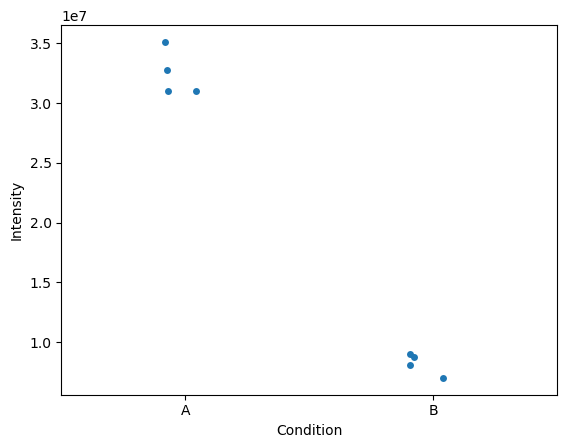

In [192]:
sns.stripplot(data1, x='Condition', y="Intensity")

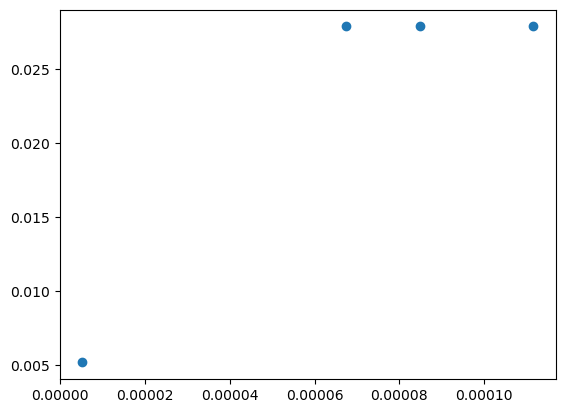

In [193]:
plt.scatter(sig.p_value, sig.q_value)

In [194]:
tidy_df

,Protein,Condition,Replicate,Intensity
0,Prot_0000,A,1,3.168069e+07
1,Prot_0000,A,2,3.152410e+07
2,Prot_0000,A,3,NaN
3,Prot_0000,A,4,3.355392e+07
4,Prot_0000,A,5,1.904292e+07
...,...,...,...,...
9995,Prot_0999,B,1,NaN
9996,Prot_0999,B,2,5.188238e+07
9997,Prot_0999,B,3,4.971476e+07
9998,Prot_0999,B,4,6.525618e+07


In [197]:
wide_df.to_csv("../data/wide_df_1pct.csv") # to upload the same synthetic data to the app

# local processing pipeline to match the app

In [131]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

def bh_qvalues(pvals: np.ndarray) -> np.ndarray:
    """Benjamini Hochberg FDR correction on a 1D array of p values."""
    p = np.asarray(pvals, dtype=float)
    m = len(p)

    order = np.argsort(p)
    ranked_p = p[order]
    ranks = np.arange(1, m + 1)

    q_sorted = ranked_p * m / ranks
    q_sorted = np.minimum.accumulate(q_sorted[::-1])[::-1]

    q_full = np.empty_like(q_sorted)
    q_full[order] = q_sorted
    return q_full

def analyze_proteomics_pipeline(
    wide_df: pd.DataFrame,
    group_A_prefix: str = "A_",
    group_B_prefix: str = "B_",
    k_neighbors: int = 5,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Pipeline:
      1. log2 transform
      2. standard scale each protein across samples
      3. KNN impute missing values (k neighbors in sample space)
      4. Welch t test between A and B
      5. BH q values

    Parameters
    ----------
    wide_df : DataFrame
        Has a 'Protein' column and sample columns like 'A_1', 'B_1', etc.

    Returns
    -------
    processed_df : DataFrame
        Protein x sample matrix after log2, scaling, and KNN imputation.

    de_table : DataFrame
        Per protein stats with columns:
        ['Protein', 'log2fc_hat', 'p_value', 'q_value', 'mean_A', 'mean_B'].
        Note: means and log2fc are on the processed (scaled, imputed) values.
    """
    # set index to Protein
    #df = wide_df.set_index("Protein")

    # 1. log2 transform
    log2_df = np.log2(wide_df+ 1e-8)

    # 2. KNN imputation (neighbors in sample space)
    imputer = KNNImputer(n_neighbors=k_neighbors)
    imputed = imputer.fit_transform(log2_df)  # samples x proteins
    processed_df = pd.DataFrame(
        imputed,
        index=log2_df.index,
        columns=log2_df.columns,
    )
    
    # 3. standard scaling per protein (across samples)
    # StandardScaler works per column, so treat proteins as features by transposing
    scaler = StandardScaler(with_mean=True, with_std=True)
    scaled = scaler.fit_transform(processed_df.T)  # samples x proteins
    scaled_df = pd.DataFrame(
        scaled.T,  # proteins x samples
        index=processed_df.index,
        columns=processed_df.columns,
    )

    # 4. t tests between A and B using processed values
    A_cols = [c for c in scaled_df.columns if c.startswith(group_A_prefix)]
    B_cols = [c for c in scaled_df.columns if c.startswith(group_B_prefix)]

    if len(A_cols) == 0 or len(B_cols) == 0:
        raise ValueError("Could not find A_*/B_* columns in wide_df")

    de_rows = []
    for prot, row in scaled_df.iterrows():
        valsA = row[A_cols].values
        valsB = row[B_cols].values

        # by construction, KNN imputation produced no NaNs, but keep the guard
        valsA = valsA[~np.isnan(valsA)]
        valsB = valsB[~np.isnan(valsB)]

        if len(valsA) < 2 or len(valsB) < 2:
            mean_A = np.nan
            mean_B = np.nan
            log2fc_hat = np.nan
            pval = np.nan
        else:
            mean_A = valsA.mean()
            mean_B = valsB.mean()
            log2fc_hat = mean_A - mean_B
            tstat, pval = stats.ttest_ind(
                valsB, valsA
            )

        de_rows.append(
            {
                "Protein": prot,
                "mean_A": mean_A,
                "mean_B": mean_B,
                "log2fc_hat": log2fc_hat,
                "p_value": pval,
            }
        )

    de_table = pd.DataFrame(de_rows)

    # 5. BH q values
    mask_valid = de_table["p_value"].notna()
    pvals = de_table.loc[mask_valid, "p_value"].values

    if pvals.size > 0:
        qvals = bh_qvalues(pvals)
        de_table["q_value"] = np.nan
        de_table.loc[mask_valid, "q_value"] = qvals
    else:
        de_table["q_value"] = np.nan

    return scaled_df, de_table


In [132]:
proc, de = analyze_proteomics_pipeline(wide_df = wide_df)

In [133]:
de[de['q_value']<0.05].sort_values('p_value')

,Protein,mean_A,mean_B,log2fc_hat,p_value,q_value
201,Prot_0201,-0.966655,0.966655,-1.933309,0.000005,0.005196
649,Prot_0649,-0.936141,0.936141,-1.872282,0.000067,0.027884
767,Prot_0767,-0.932269,0.932269,-1.864538,0.000085,0.027884
94,Prot_0094,0.927356,-0.927356,1.854711,0.000112,0.027884


# comparison of local heatmap

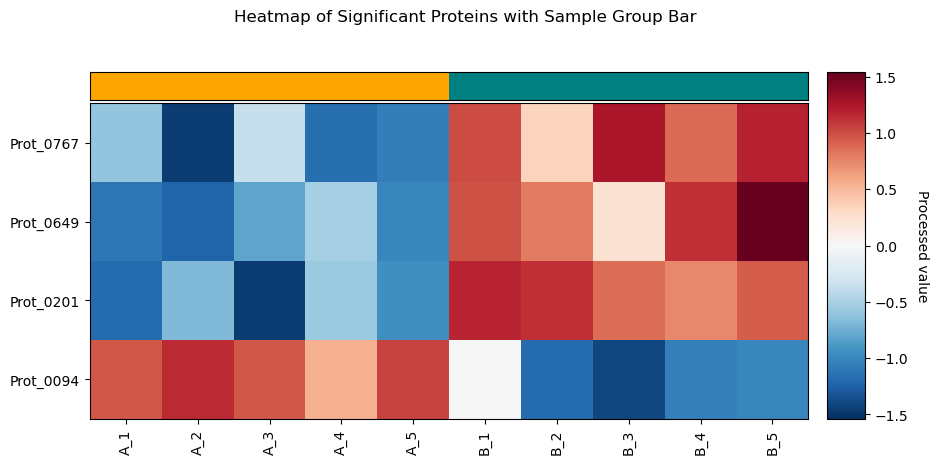

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1. explicit row order
desired_order = ["Prot_0767", "Prot_0649", "Prot_0201", "Prot_0094"]
desired_order = [p for p in desired_order if p in proc.index]

# 2. subset processed matrix
heat_df = proc.loc[desired_order]

# 3. sample order
cols_ordered = sorted(
    heat_df.columns,
    key=lambda c: (0 if c.startswith("A_") else 1, c)
)
heat_df = heat_df[cols_ordered]

# 4. group strip values (0 = A, 1 = B)
group_vals = np.array([0 if c.startswith("A_") else 1 for c in cols_ordered])[None, :]
group_cmap = ListedColormap(["orange", "teal"])

# 5. figure with 2x2 gridspec:
#   [group_strip | colorbar (empty)]
#   [heatmap     | colorbar]
fig = plt.figure(figsize=(10, 4.5))
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    height_ratios=[0.08, 0.92],
    width_ratios=[0.95, 0.05],
    hspace=0.02, wspace=0.05
)

ax0 = fig.add_subplot(gs[0, 0])   # group strip
ax1 = fig.add_subplot(gs[1, 0])   # heatmap
cax = fig.add_subplot(gs[:, 1])   # colorbar column spanning both rows

# 6. group strip
ax0.imshow(group_vals, aspect='auto', cmap=group_cmap, vmin=0, vmax=1)
ax0.set_xticks([])
ax0.set_yticks([])

# 7. heatmap
vmax = np.nanmax(np.abs(heat_df.values))

im = ax1.imshow(
    heat_df.values,
    aspect='auto',
    cmap='RdBu_r',
    vmin=-vmax,
    vmax=+vmax
)

ax1.set_xticks(np.arange(len(cols_ordered)))
ax1.set_xticklabels(cols_ordered, rotation=90)

ax1.set_yticks(np.arange(len(desired_order)))
ax1.set_yticklabels(desired_order)

# 8. colorbar in its own axis
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Processed value", rotation=270, labelpad=15)

plt.suptitle("Heatmap of Significant Proteins with Sample Group Bar", y=1.02)
plt.savefig('../figures/heatmap-1pct.svg', bbox_inches='tight')
plt.show()


# comparison of app and local processing results

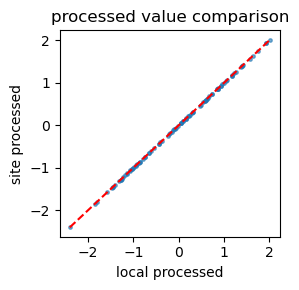

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load your local processed matrix
proc_local = proc.copy()

# load the first-ten-rows export from the site
proc_site = pd.read_csv("../data/2025-11-21T00-02_export.csv", index_col=0)

# make sure indexes match
shared_proteins = proc_local.index.intersection(proc_site.index)

if len(shared_proteins) == 0:
    raise ValueError("no overlapping proteins. check index names or file format.")

proc_local_sub = proc_local.loc[shared_proteins]
proc_site_sub = proc_site.loc[shared_proteins]

# align columns
shared_cols = proc_local_sub.columns.intersection(proc_site_sub.columns)

proc_local_sub = proc_local_sub[shared_cols]
proc_site_sub = proc_site_sub[shared_cols]

# flatten for scatter and bland altman
vals_local = proc_local_sub.values.flatten()
vals_site = proc_site_sub.values.flatten()

mask = ~np.isnan(vals_local) & ~np.isnan(vals_site)
vals_local = vals_local[mask]
vals_site = vals_site[mask]

# scatter plot
plt.figure(figsize=(3,3))
plt.scatter(vals_local, vals_site, s=6, alpha=0.6)
mn = min(vals_local.min(), vals_site.min())
mx = max(vals_local.max(), vals_site.max())
plt.plot([mn, mx], [mn, mx], "r--")
plt.xlabel("local processed")
plt.ylabel("site processed")
plt.title("processed value comparison")
plt.tight_layout()

plt.savefig('../figures/scatter_processed_data.svg', bbox_inches='tight')
plt.show()


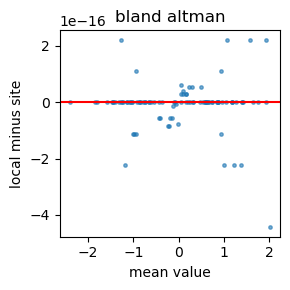

max absolute difference: 4.440892098500626e-16
mean absolute difference: 3.7539416020138107e-17
correlation: 0.9999999999999998


<Figure size 640x480 with 0 Axes>

In [171]:
# bland altman
mean_vals = (vals_local + vals_site) / 2
diff_vals = vals_local - vals_site

plt.figure(figsize=(3,3))
plt.scatter(mean_vals, diff_vals, s=6, alpha=0.6)
plt.axhline(0, color="r")
plt.xlabel("mean value")
plt.ylabel("local minus site")
plt.title("bland altman")
plt.tight_layout()
plt.show()

# numeric summary
abs_diff = np.abs(vals_local - vals_site)
print("max absolute difference:", abs_diff.max())
print("mean absolute difference:", abs_diff.mean())
print("correlation:", np.corrcoef(vals_local, vals_site)[0,1])
plt.savefig('../figures/bland_altman_proc.svg', bbox_inches='tight')



In [139]:
app_stats = pd.read_csv('../data/proteomics_statistical_results.csv')
app_stats

,protein,B_mean,B_std,A_mean,A_std,log2_fold_change,test_statistic,p_value,p_value_corrected,significant,neg_log10_pvalue,abs_log2_fold_change
0,Prot_0000,-0.242450,0.878302,0.242450,1.054050,0.484900,-0.706842,0.499732,0.991531,False,0.003694,0.484900
1,Prot_0001,-0.347860,1.156724,0.347860,0.648057,0.695720,-1.049438,0.324643,0.949360,False,0.022569,0.695720
2,Prot_0002,0.169876,1.001315,-0.169876,0.969357,-0.339753,0.487569,0.638935,0.997527,False,0.001075,0.339753
3,Prot_0003,-0.404017,0.914681,0.404017,0.914822,0.808034,-1.249227,0.246894,0.942475,False,0.025730,0.808034
4,Prot_0004,0.028648,1.223315,-0.028648,0.708421,-0.057296,0.081062,0.937384,0.999550,False,0.000196,0.057296
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Prot_0995,0.413303,0.798294,-0.413303,1.010489,-0.826607,1.283777,0.235152,0.942475,False,0.025730,0.826607
996,Prot_0996,0.186301,0.405101,-0.186301,1.329089,-0.372602,0.536329,0.606319,0.997527,False,0.001075,0.372602
997,Prot_0997,0.019958,0.672191,-0.019958,1.243930,-0.039916,0.056461,0.956359,0.999550,False,0.000196,0.039916
998,Prot_0998,0.310767,0.975433,-0.310767,0.924867,-0.621534,0.924771,0.382133,0.959623,False,0.017899,0.621534


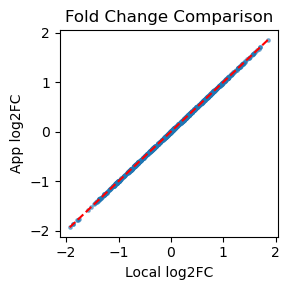

In [174]:
plt.figure(figsize=(3,3))
plt.scatter(de["log2fc_hat"], app_stats["log2_fold_change"], s=6, alpha=0.5)
mn = min(de["log2fc_hat"].min(), app_stats["log2_fold_change"].min())
mx = max(de["log2fc_hat"].max(), app_stats["log2_fold_change"].max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("Local log2FC")
plt.ylabel("App log2FC")
plt.title("Fold Change Comparison")
plt.tight_layout()
plt.savefig('../figures/fold_change_proc.svg', bbox_inches='tight')

plt.show()


In [181]:
-np.log10(de["p_value"]).max()

0      0.301263
1      0.488594
2      0.194543
3      0.607490
4      0.028083
         ...   
995    0.628651
996    0.217299
997    0.019379
998    0.417785
999    0.550690
Name: p_value, Length: 1000, dtype: float64

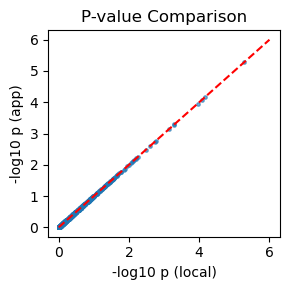

In [182]:
plt.figure(figsize=(3,3))
plt.scatter(-np.log10(de["p_value"]), -np.log10(app_stats["p_value"]), s=6, alpha=0.6)
mn = 0
mx = 6
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("-log10 p (local)")
plt.ylabel("-log10 p (app)")
plt.title("P-value Comparison")
plt.tight_layout()
plt.savefig('../figures/pval_proc.svg', bbox_inches='tight')

plt.show()

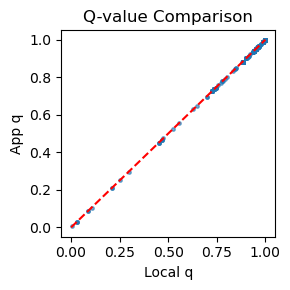

In [183]:
plt.figure(figsize=(3,3))
plt.scatter(de["q_value"], app_stats["p_value_corrected"], s=6, alpha=0.6)
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("Local q")
plt.ylabel("App q")
plt.title("Q-value Comparison")
plt.tight_layout()
plt.savefig('../figures/qval_proc.svg', bbox_inches='tight')

plt.show()